# Part 2: Interactive QA Bot Interface
 ## Problem Statement:
 Develop an interactive interface for the QA bot from Part 1, allowing users to input queries
 and retrieve answers in real time. The interface should enable users to upload documents
 and ask questions based on the content of the uploaded document.
 ## Task Requirements:
 1. Build a simple frontend interface using Streamlit or Gradio, allowing users to
 upload PDF documents and ask questions.
 2. Integrate the backend from Part 1 to process the PDF, store document embeddings,
 and provide real-time answers to user queries.
 3. Ensure that the system can handle multiple queries efficiently and provide accurate,
 contextually relevant responses.
 4. Allow users to see the retrieved document segments alongside the generated
 answer.

# RAG Work Flow

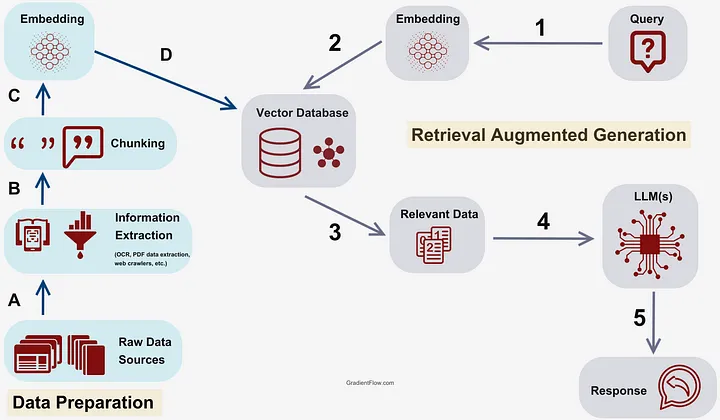

# Overview
- Model = Groq(llama-3.1-70b-versatile)
- Vector database = Faiss
- Retrieval with Langchain Framework
- UI = Gradio
- Model tracking = Langsmith
- load url with WebBaseLoader
- embeddings through huggingface api
- split documents with RecursiveCharacterTextSplitter

# Install necessary dependencies

In [1]:
!pip install --upgrade --quiet langchain_community langchain pypdf faiss-cpu langchain-groq langchain-huggingface gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.6/396.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.3/2

# Import necessary Libraries

In [2]:
import os
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain_community.embeddings import HuggingFaceInferenceAPIEmbeddings
from google.colab import userdata
from langchain_community.vectorstores import FAISS
from langchain import hub
from langchain.chains import RetrievalQA
from langchain_groq import ChatGroq
import gradio as gr
import tempfile

# set environment of api keys
Hug_api_key=userdata.get('hug_api_key') # huggingface api
os.environ["GROQ_API_KEY"] = userdata.get("groq_api_key") # groq api
os.environ['LANGCHAIN_API_KEY']=userdata.get('LANGCHAIN_API_KEY') # langchain api

# set langsmith to trach the calls
LANGCHAIN_TRACING_V2="true"
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_PROJECT="Rag based approach"

# embeding initialisation
embeddings = HuggingFaceInferenceAPIEmbeddings(api_key=Hug_api_key, model_name="sentence-transformers/all-MiniLM-l6-v2")

# LLM
llm = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    max_tokens=600,
    timeout=None,
    max_retries=2,
)

In [3]:
# Create a Vector Store from uploaded PDF files
def create_vector_store(pdf_files):
    text = []

    for pdf_file in pdf_files:
        # Handle the file correctly using its path attribute
        pdf_path = pdf_file.name  # Get the path of the uploaded file

        # Load the content of the PDF
        loader = PyPDFLoader(pdf_path)
        text.extend(loader.load())

        # Optional: Remove the file if necessary
        # os.remove(pdf_path)  # Uncomment if you wish to remove the uploaded file after processing

    # Split the document into chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=4000, chunk_overlap=10)
    text_chunks = text_splitter.split_documents(text)

    vector_store = FAISS.from_documents(text_chunks, embedding=embeddings)

    return vector_store


In [4]:
# Create the Conversational Chain with memory
def create_conversational_chain(llm, vector_store):
    memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
    chain = ConversationalRetrievalChain.from_llm(
        llm=llm,
        chain_type='stuff',
        retriever=vector_store.as_retriever(search_kwargs={"k": 2}),
        memory=memory
    )
    return chain

In [5]:
# Handle the upload and chat logic
vector_store = None
conversational_chain = None



In [6]:
def upload_pdf(pdf_files):
    global vector_store, conversational_chain
    vector_store = create_vector_store(pdf_files)
    if vector_store:
        conversational_chain = create_conversational_chain(llm, vector_store)
        return "PDFs successfully processed. You can now ask questions!"
    else:
        return "Failed to process PDFs. Please try again."

In [7]:
def ask_question(question):
    if conversational_chain and vector_store:
        result = conversational_chain.invoke({"question": question, "chat_history": []})
        # print(result.keys())
        # print(result)
        return result["answer"]
    else:
        return "Please upload PDFs first."


In [9]:
# Creating the Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("## PDF-Based Q&A Chatbot")

    with gr.Row():
        pdf_input = gr.File(label="Upload PDF Files", file_count="multiple", type="filepath")
        upload_button = gr.Button("Process PDFs")
        status_output = gr.Textbox(label="Status", interactive=False)

    with gr.Row():
        question_input = gr.Textbox(label="Ask a Question")
        ask_button = gr.Button("Ask")
        answer_output = gr.Textbox(label="Answer", interactive=True)

    # Event handlers
    upload_button.click(upload_pdf, inputs=[pdf_input], outputs=[status_output])
    ask_button.click(ask_question, inputs=[question_input], outputs=[answer_output])

# Launch the GUI in Colab
demo.launch(debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://17967a9c0290d8b895.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://17967a9c0290d8b895.gradio.live


# Demo of working app
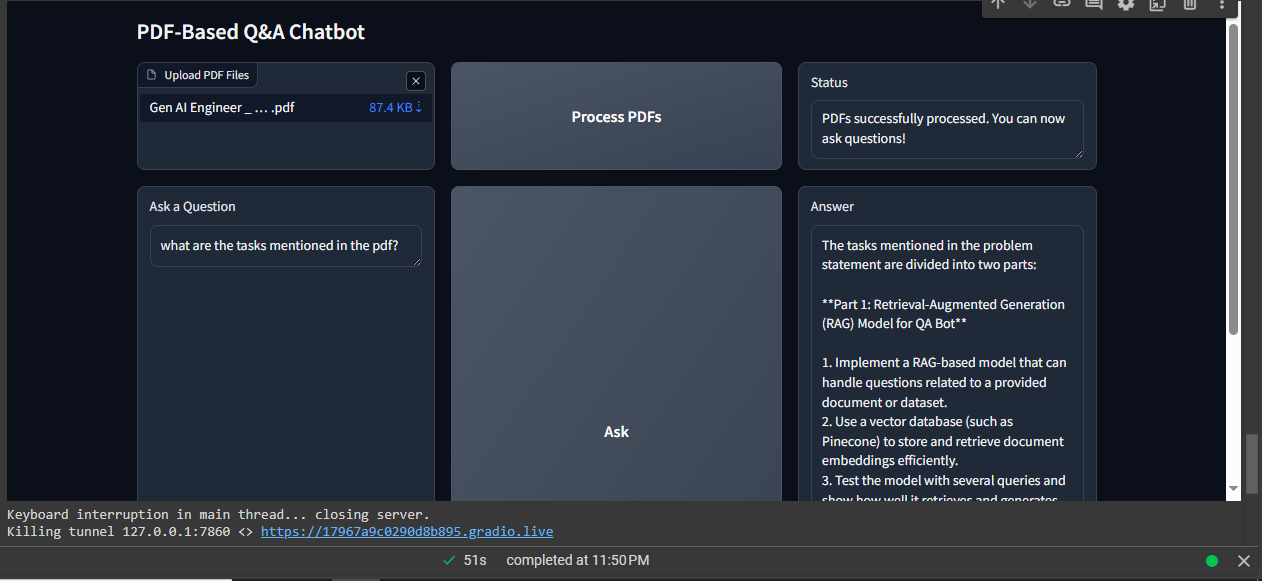